# PyTorch class-based neural net

In this workbook we build a neural network to predict survival. The two common frameworks used for neural networks (as of 2020) are TensorFlow and PyTorch. Both are excellent frameworks. TensorFlow frequently requires fewer lines of code, but PyTorch is more natively Python in its syntax, and also allows for easier debugging as the model may be interrupted, with a breakpoint, and debugged as necessary. This makes PyTorch particularly suitable for research and experimentation. A disadvantage of using PyTorch is that, compared with TensorFlow, there are fewer training materials and examples available.

Both TensorFlow and PyTorch allow the neural network to be trained on a GPU, which is beneficial for large neural networks (especially those processing image, sound or free-text data). In order to lever the benefits of GPU (which perform many calculations simultaneously), data is grouped into batches. These batches are presented to the CPU in a single object called a Tensor (a multi-dimensional array). 

Installation instructions for PyTorch may be found at pytorch.org. (If in doubt about what installation to use, use `pip install` and use CPU-only, not CUDA). If you are using Anaconda then it is advised to create a new environment, and install pytorch, numpy, pandas, sci-kit learn and matplotlib into that new environment. For more on Anaconda environments see: https://docs.anaconda.com/anaconda/navigator/tutorials/manage-environments/

There are two versions of this workbook. This version uses a class-based method which offers some more flexibility (but at the cost of a little simplicity). The alternative version uses simpler form but at the cost of some flexibility. It is recommended to work through both methods.

It is not the intention here to describe neural networks in any detail, but rather give some introductory code to using a neural network for a classification problem. For an introduction to neural networks see: https://en.wikipedia.org/wiki/Artificial_neural_network

The code for PyTorch here keeps all calculations on the CPU rather than passing to a GPU (if you have one). Running neural networks on CPUs is fine for small amounts of structured data such as our Titanic data. GPUs come in to their own for large sets of data or unstructured data like images, sound clips, or free text.

The training process of a neural network consists of three general phases which are repeated across all the data. All of the data is passed through the network multiple times (the number of iterations, which may be as few as 3-5 or may be 100+). The three phases are:

* Pass training X data to the network and predict y
* Calculate the 'loss' (error) between the predicted and observed (actual) values of y
* Adjust the network a little (as defined by the learning rate) so that the error is reduced. The correction of the network is performed by PyTorch or TensorFlow using a technique called 'back-propagation'.

The learning is repeated until maximum accuracy is achieved (but keep an eye on accuracy of test data as well as training data as the network may develop significant over-fitting to training data unless steps are taken to offset the potential for over-fitting, such as use of 'drop-out' layers described below).

Note: Neural Networks are most often used for complex unstructured data. For structured data, other techniques, such as Random Forest,s may frequently be preferred.

## Load modules

In [1]:
import numpy as np
import pandas as pd

# sklearn for pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

# pytorch
import torch
from torch.autograd import Variable
import torch.nn.functional as F

## Download data if not previously downloaded

In [2]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)
    # Make all data 'float' type
    data = data.astype(float)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

## Define function to calculate accuracy measurements

In [3]:
import numpy as np

def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate: Same as specificity
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    false_negatives = (predicted_negatives == 1) & (observed_negatives == 0)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                            (np.sum(true_positives) + np.sum(false_positives)))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                            (np.sum(true_negatives) + np.sum(false_negatives)))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

## Define function to scale data

In neural networks it is common to to scale input data 0-1 rather than use standardisation (subtracting mean and dividing by standard deviation) of each feature).

In [4]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc

## Load data

In [5]:
data = pd.read_csv('data/processed_data.csv')
data.drop('PassengerId', inplace=True, axis=1)
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'
# Convert to NumPy as required for k-fold splits
X_np = X.values
y_np = y.values

# Set up neural net

Here we use the class-based method to set up a PyTorch neural network. The network is the same as the sequential network we previously used, but is built using 

We will put construction of the neural net into a separate function.

The neural net is a relatively simple network. The inputs are connected to two hidden layers (of 240 and 50 nodes) before being connected to two output nodes corresponding to each class (died and survived). It also contains some useful additions (batch normalisation and dropout) as described below.

The layers of the network are:

1) An input layer (which *does* need to be explicitly defined when using the class method). 

2) A linear fully-connected (dense) layer.This is defined by the number of inputs (the number of input features) and the number of nodes/outputs. Each node will receive the values of all the inputs (which will either be the feature data for the input layer, or the outputs from the previous layer - so that if the previous layer had 10 nodes, then each node of the current layer would have 10 inputs, one from each node of the previous layer). It is a linear layer because the output of the node at this point is a linear function of the dot product of the weights and input values. We will expand out feature data set up to 240 outputs. 

3) A batch normalisation layer. This is not usually used for small models, but can increase the speed of training and stability for larger models. It is added here as an example of how to include it (in large models all dense layers would be followed by a batch normalisation layer). Using batch normalisation usually allows for a higher learning rate. The layer definition includes the number of inputs to normalise.

4) A dropout layer. This layer randomly sets outputs from the preceding layer to zero during training (a different set of outputs is zeroed for each training iteration). This helps prevent over-fitting of the model to the training data. Typically between 0.1 and 0.3 outputs are set to zero (`p=0.1` means 10% of outputs are set to zero).

5) An activation layer. In this case ReLU (rectified linear unit). ReLU activation is most common for the inner layers of a neural network. Negative input values are set to zero. Positive input values are left unchanged.

6) A second linear fully connected layer which reduces the network down to 50 nodes. This is again followed by batch normalisation, dropout and ReLU activation layers.

7) A final fully connected linear layer of two nodes (more nodes could be used for more classes).

8) Apply sigm0id activation to convert each output node to range 0-1 output.

The output of the net are two numbers (corresponding to scored for died/survived) between 0 and 1. These do not necessarily add up exactly to one. The one with the highest value is taken as the classification result.


# Set up neural net

In [6]:
class Net(torch.nn.Module):
    
    def __init__(self, number_features):
        # Define layers
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(number_features, 240)
        self.bn1 = torch.nn.BatchNorm1d(240)
        self.fc2 = torch.nn.Linear(240, 50)
        self.bn2 = torch.nn.BatchNorm1d(50)
        self.fc3 = torch.nn.Linear(50, 2)
        
    def forward(self, x):
        # Define sequence of layers
        x = self.fc1(x) # Fully connected layer
        x = self.bn1(x) # Batch normalisation
        x = F.dropout(x, p=0.1) # Apply dropout
        x = F.relu(x) # ReLU activation
        x = self.fc2(x) # Fully connected layer
        x = self.bn2(x) # Batch normalisation
        x = F.dropout(x, p=0.1) # Apply dropout
        x = F.relu(x) # ReLU activation
        x = self.fc3(x) # Fully connected layer
        x = torch.sigmoid(x) # Sigmoid output (0-1)
        
        return x

## Run the model with k-fold validation

In [7]:
# Set up lists to hold results
training_acc_results = []
test_acc_results = []

# Set up splits
skf = StratifiedKFold(n_splits = 5)
skf.get_n_splits(X_np, y_np)

# Loop through the k-fold splits
k_counter = 0

for train_index, test_index in skf.split(X, y):
    k_counter +=1
    print('K_fold {}'.format(k_counter),end=' ')
    
    # Get X and Y train/test
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]
    
    # Scale X data
    X_train_sc, X_test_sc = scale_data(X_train, X_test)
    
    # Define network
    number_features = X_train_sc.shape[1]
        
    net = Net(number_features)
    
    ### Train model
    # Note: Lots of these parameters may be fine tuned
    
    # Set batch size (cases per batch - commonly 8-64)
    batch_size = 16
    # Epochs (number of times to pass over data)
    num_epochs = 200
    # Learning rate (how much each bacth updates the model)
    learning_rate = 0.003
    # Calculate numebr of batches
    batch_no = len(X_train_sc) // batch_size

    # Set up optimizer for classification
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # Train model by passing through the data the required number of epochs
    for epoch in range(num_epochs):
        for i in range(batch_no):
            
            # Get X and y batch data
            start = i * batch_size
            end = start + batch_size
            x_var = Variable(torch.FloatTensor(X_train_sc[start:end]))
            y_var = Variable(torch.LongTensor(y_train[start:end]))
            
            # These steps train the model: Forward + Backward + Optimize
            optimizer.zero_grad() # reset optimizer
            ypred_var = net(x_var) # predict y
            loss = criterion(ypred_var, y_var) # Calculate loss
            loss.backward() # Back propagate loss through network
            optimizer.step() # Update network to reduce loss
            
    # Test model
    
    test_var = Variable(torch.FloatTensor(X_train_sc))
    result = net(test_var)
    values, labels = torch.max(result, 1)
    y_pred_train = labels.data.numpy()
    accuracy_train = np.mean(y_pred_train == y_train)
    training_acc_results.append(accuracy_train)
    
    test_var = Variable(torch.FloatTensor(X_test_sc))
    result = net(test_var)
    values, labels = torch.max(result, 1)
    y_pred_test = labels.data.numpy()
    accuracy_test = np.mean(y_pred_test == y_test)
    print(accuracy_test)
    test_acc_results.append(accuracy_test)

K_fold 1 0.7932960893854749
K_fold 2 0.7808988764044944
K_fold 3 0.8033707865168539
K_fold 4 0.7584269662921348
K_fold 5 0.8426966292134831


## Show training and test results

In [8]:
# Show individual accuracies on training data
training_acc_results

[0.8539325842696629,
 0.8639551192145862,
 0.8569424964936886,
 0.8569424964936886,
 0.8302945301542777]

In [9]:
# Show individual accuracies on test data
test_acc_results

[0.7932960893854749,
 0.7808988764044944,
 0.8033707865168539,
 0.7584269662921348,
 0.8426966292134831]

In [10]:
# Get mean results
mean_training = np.mean(training_acc_results)
mean_test = np.mean(test_acc_results)

# Display each to three decimal places
print ('{0:.3f}, {1:.3}'.format(mean_training,mean_test))

0.852, 0.796


## Plot results: Box Plot

Box plots show median (orange line), the second and third quartiles (the box), the range (excluding outliers), and any outliers as 'whisker' points. Outliers, by convention, are considered to be any points outside of the quartiles +/- 1.5 times the interquartile range. The limit for outliers may be changed using the optional `whis` argument in the boxplot.

Medians tend to be an easy reliable guide to the centre of a distribution (i.e. look at the medians to see whether a fit is improving or not, but also look at the box plot to see how much variability there is).

Test sets tend to be more variable in their accuracy measures. Can you think why?

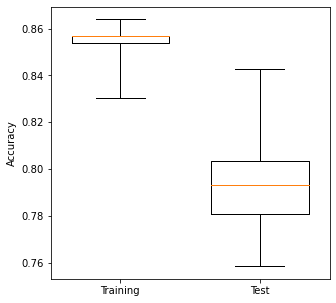

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# Set up X data 
x_for_box = [training_acc_results, test_acc_results]

# Set up X labels
labels = ['Training', 'Test'] 

# Set up figure
fig = plt.figure(figsize=(5,5))

# Add subplot (can be used to define multiple plots in same figure)
ax1 = fig.add_subplot(111)

# Define Box Plot (`widths` is optional)
ax1.boxplot(x_for_box, 
            widths=0.7,
            whis=10)

# Set X and Y labels
ax1.set_xticklabels(labels)
ax1.set_ylabel('Accuracy')

# Show plot
plt.show()